Connected to base (Python 3.12.7)

In [ ]:
#!/usr/bin/env python
# %%
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Configuration
LOCAL_BASE_DIR = "/Data/aa/FoodCNN/datasets/nutrition5k"
IMAGERY_DIR_LOCAL_FULL = os.path.join(LOCAL_BASE_DIR, "imagery/realsense_overhead")
METADATA_FILE_CAFE1 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe1.csv")
METADATA_FILE_CAFE2 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe2.csv")
RGB_IMAGE_FILENAME = "rgb.png"

Found 3490 dish IDs with RGB images
Loading SAM model...
Processing images in batches...
Creating visualization...


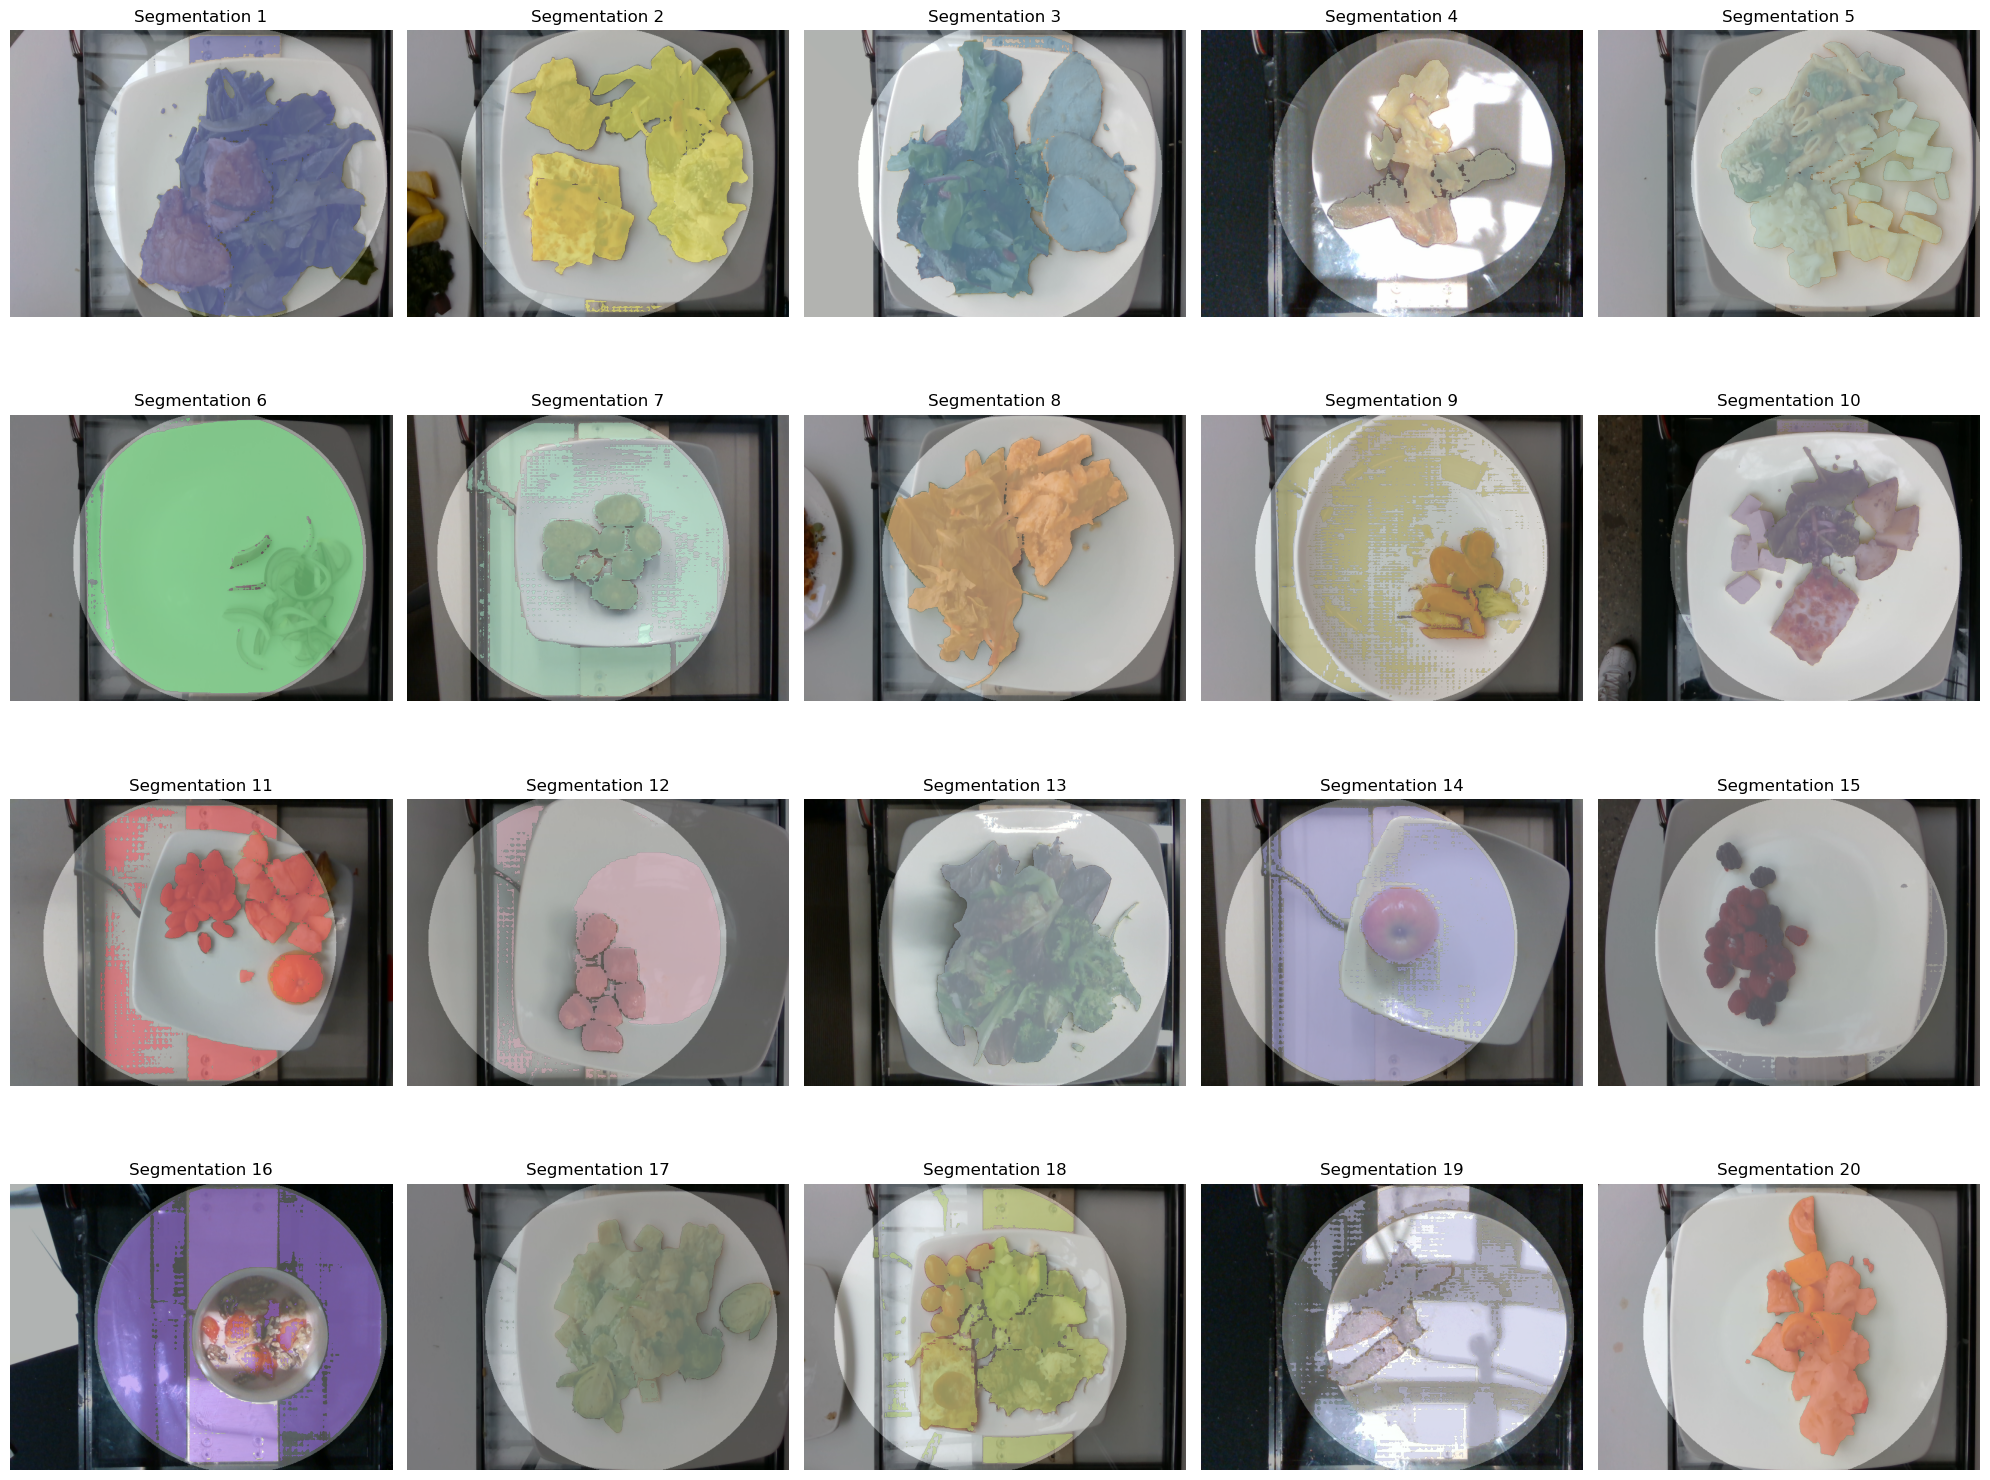

In [ ]:

BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
TARGET_COLUMNS = ["calories", "weight", "fat", "carbs", "protein"]


SAM_CHECKPOINT = "sam_vit_h_4b8939.pth"  
SAM_MODEL_TYPE = "vit_h"

def load_sam_model():
    """Load the SAM model."""
    sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
    sam.to(device=DEVICE)
    return sam

def remove_shadows(image):
    """Remove shadows from the image while preserving important color information."""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    
    lab = cv2.merge([l, a, b])
    
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    rgb = cv2.bilateralFilter(rgb, 9, 75, 75)
    
    return rgb

def preprocess_image(image):
    """Preprocess image to identify dish boundaries using adaptive shape analysis."""
    h, w = image.shape[:2]
    initial_center_x, initial_center_y = w // 2, h // 2
    
    enhanced_image = remove_shadows(image)
    
    hsv = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2HSV)
    
    max_radius = min(w, h)
    min_radius = 20  # Minimum radius to consider
    step_size = 5    # Step size for radius increase
    color_threshold = 5  # Lower threshold for more gradual detection
    min_dish_radius = min(w, h) // 2  # Minimum expected dish radius
    
    def get_region_color(center_x, center_y, radius):
        """Get average color in a region around the given center."""
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (center_x, center_y), radius, 255, -1)
        
        mean_color = cv2.mean(hsv, mask=mask)[:3]
        std_color = cv2.meanStdDev(hsv, mask=mask)[1][:3, 0]
        
        if np.mean(std_color) > 30:  # Threshold for shadow detection
            angles = np.linspace(0, 2*np.pi, 16)
            colors = []
            for angle in angles:
                x = int(center_x + radius * np.cos(angle))
                y = int(center_y + radius * np.sin(angle))
                if 0 <= x < w and 0 <= y < h:
                    colors.append(hsv[y, x])
            
            if colors:
                colors = np.array(colors)
                mean_color = np.median(colors, axis=0)
        
        return mean_color
    
    def find_best_center(radius):
        """Find the best center point for the given radius."""
        best_center = (initial_center_x, initial_center_y)
        best_stability = float('inf')
        
        search_radius = radius // 2
        for dx in range(-search_radius, search_radius + 1, step_size):
            for dy in range(-search_radius, search_radius + 1, step_size):
                center_x = initial_center_x + dx
                center_y = initial_center_y + dy
                
                if (center_x < radius or center_x > w - radius or 
                    center_y < radius or center_y > h - radius):
                    continue
                
                angles = np.linspace(0, 2*np.pi, 16)
                colors = []
                for angle in angles:
                    x = int(center_x + radius * np.cos(angle))
                    y = int(center_y + radius * np.sin(angle))
                    if 0 <= x < w and 0 <= y < h:
                        colors.append(hsv[y, x])
                
                if colors:
                    colors = np.array(colors)
                    stability = np.median(np.abs(colors - np.median(colors, axis=0)), axis=0).mean()
                    if stability < best_stability:
                        best_stability = stability
                        best_center = (center_x, center_y)
        
        return best_center
    
    center_x, center_y = initial_center_x, initial_center_y
    prev_color = get_region_color(center_x, center_y, min_radius)
    dish_radius = min_radius
    
    for radius in range(min_radius + step_size, max_radius, step_size):
        if radius % (step_size * 4) == 0:
            center_x, center_y = find_best_center(radius)
        
        current_color = get_region_color(center_x, center_y, radius)
        color_diff = np.linalg.norm(np.array(current_color) - np.array(prev_color))
        
        if color_diff > color_threshold and radius > min_dish_radius:
            dish_radius = radius
            break
        
        prev_color = current_color
    
    dish_radius = max(dish_radius, min_dish_radius)
    
    dish_mask = np.zeros((h, w), dtype=np.uint8)
    
    def analyze_region(x, y, radius):
        """Analyze if a point belongs to the dish based on color transitions."""
        if not (0 <= x < w and 0 <= y < h):
            return False
            
        point_color = hsv[y, x]
        
        neighborhood = hsv[max(0, y-2):min(h, y+3), max(0, x-2):min(w, x+3)]
        if neighborhood.size == 0:
            return False
        center_color = get_region_color(center_x, center_y, radius)
        color_diff = np.linalg.norm(point_color - center_color)
        
        dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        
        return (color_diff < color_threshold * 1.5 and 
                dist < radius * 1.2 and
                (dist < radius * 0.8 or  # Always include points close to center
                 np.any(dish_mask[max(0, y-3):min(h, y+4), max(0, x-3):min(w, x+4)])))  # Or near existing dish points
    
    points_to_check = [(center_x, center_y)]
    checked_points = set()
    
    while points_to_check:
        x, y = points_to_check.pop(0)
        if (x, y) in checked_points:
            continue
            
        checked_points.add((x, y))
        
        if analyze_region(x, y, dish_radius):
            dish_mask[y, x] = 255
            
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]:
                new_x, new_y = x + dx, y + dy
                if (new_x, new_y) not in checked_points:
                    points_to_check.append((new_x, new_y))
    
    kernel = np.ones((3,3), np.uint8)
    dish_mask = cv2.morphologyEx(dish_mask, cv2.MORPH_CLOSE, kernel)
    dish_mask = cv2.morphologyEx(dish_mask, cv2.MORPH_OPEN, kernel)
    y_indices, x_indices = np.where(dish_mask > 0)
    if len(y_indices) > 0 and len(x_indices) > 0:
        x = np.min(x_indices)
        y = np.min(y_indices)
        w = np.max(x_indices) - x + 1
        h = np.max(y_indices) - y + 1
    else:
        cv2.circle(dish_mask, (center_x, center_y), dish_radius, 255, -1)
        x = max(0, center_x - dish_radius)
        y = max(0, center_y - dish_radius)
        w = min(image.shape[1] - x, dish_radius * 2)
        h = min(image.shape[0] - y, dish_radius * 2)
    
    dish_bbox = (x, y, w, h)
    
    return dish_bbox, dish_mask

def segment_food_dish(image_path, sam_model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    dish_bbox, dish_mask = preprocess_image(image)
    x, y, w, h = dish_bbox
    
    predictor = SamPredictor(sam_model)
    predictor.set_image(image)
    
    points = []
    
    for px in range(x + 10, x + w - 10, 15):
        for py in range(y + 10, y + h - 10, 15):
            if dish_mask[py, px] > 0:
                points.append([px, py])
    
    center_x, center_y = x + w//2, y + h//2
    radius = min(w, h) // 4 
    for angle in range(0, 360, 8): 
        rad = np.radians(angle)
        px = center_x + int(radius * np.cos(rad))
        py = center_y + int(radius * np.sin(rad))
        if 0 <= px < image.shape[1] and 0 <= py < image.shape[0]:
            if dish_mask[py, px] > 0:
                points.append([px, py])
    
    input_points = np.array(points)
    
    input_box = np.array([
        x + w//8, y + h//8, 
        x + w*7//8, y + h*7//8 
    ])
    
    masks, scores, _ = predictor.predict(
        point_coords=input_points,
        point_labels=np.ones(len(input_points)),
        box=input_box,
        multimask_output=True
    )
    
    best_mask_idx = np.argmax(scores)
    best_mask = masks[best_mask_idx]
    
    if np.any(best_mask):
        y_indices, x_indices = np.where(best_mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            min_x, max_x = np.min(x_indices), np.max(x_indices)
            min_y, max_y = np.min(y_indices), np.max(y_indices)
            
            refine_points = []
            for px in range(min_x, max_x, 8): 
                for py in range(min_y, max_y, 8):
                    if best_mask[py, px]: 
                        refine_points.append([px, py])
            
            if refine_points:
                refine_points = np.array(refine_points)
                refined_masks, refined_scores, _ = predictor.predict(
                    point_coords=refine_points,
                    point_labels=np.ones(len(refine_points)),
                    box=input_box,
                    multimask_output=True
                )
                
                if np.max(refined_scores) > scores[best_mask_idx]:
                    best_mask = refined_masks[np.argmax(refined_scores)]
    
    mask_list = [{
        'segmentation': best_mask,
        'area': np.sum(best_mask),
        'bbox': [min_x, min_y, max_x - min_x, max_y - min_y] if 'min_x' in locals() else [x, y, w, h],
        'predicted_iou': scores[best_mask_idx],
        'stability_score': scores[best_mask_idx],
        'crop_box': [x, y, w, h],
        'point_coords': input_points.tolist()
    }]
    
    if np.any(best_mask):
        constraint_mask = np.zeros_like(best_mask, dtype=np.uint8)  
        center_x, center_y = x + w//2, y + h//2
        radius = min(w, h) // 2
        cv2.circle(constraint_mask, (center_x, center_y), radius, 1, -1)
        
        constraint_mask = constraint_mask.astype(bool)
        
        best_mask = np.logical_and(best_mask, constraint_mask)
        
        mask_list[0]['segmentation'] = best_mask
    
    return image, mask_list, dish_mask

def visualize_segmentation(image, masks, dish_mask=None):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(221)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    if dish_mask is not None:
        plt.subplot(222)
        plt.imshow(dish_mask, cmap='gray')
        plt.title('Dish Detection')
        plt.axis('off')
    
    plt.subplot(223)
    plt.imshow(image)
    for mask in masks:
        show_mask(mask['segmentation'], plt.gca(), random_color=False)
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.subplot(224)
    plt.imshow(image)
    for mask in masks:
        show_mask(mask['segmentation'], plt.gca(), random_color=True)
        if 'point_coords' in mask:
            points = np.array(mask['point_coords'])
            plt.scatter(points[:, 0], points[:, 1], c='yellow', s=10, alpha=0.5)
    plt.title('Overlay with Points')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def show_mask(mask, ax, random_color=False):
    """Show a mask on the given axis with improved visibility."""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.5])], axis=0)
    else:
        color = np.array([1, 0, 0, 0.5])  # Red with 50% opacity
    
    # Handle both single mask and list of masks
    if isinstance(mask, list):
        mask = mask[0]['segmentation']  # Get the first mask's segmentation
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def visualize_segmentation_grid(images, masks, dish_masks=None, num_cols=5):
    """Create a grid visualization of segmentation masks."""
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    plt.figure(figsize=(20, 4 * num_rows))
    
    for idx in range(num_images):
        plt.subplot(num_rows, num_cols, idx + 1)
        # Show original image as background
        plt.imshow(images[idx])
        # Overlay segmentation mask
        show_mask(masks[idx], plt.gca(), random_color=True)
        if dish_masks is not None:
            plt.imshow(dish_masks[idx], alpha=0.3, cmap='gray')
        plt.title(f'Segmentation {idx + 1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def process_batch(image_paths, sam_model, batch_size=4):
    """Process a batch of images in parallel."""
    results = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_results = []
        
        for image_path in batch_paths:
            try:
                image, mask, dish_mask = segment_food_dish(image_path, sam_model)
                batch_results.append((image, mask, dish_mask))
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                continue
        
        results.extend(batch_results)
    
    return results

available_dish_ids_in_imagery = []
for dish_id_folder in os.listdir(IMAGERY_DIR_LOCAL_FULL):
    rgb_path = os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id_folder, RGB_IMAGE_FILENAME)
    if os.path.isdir(
        os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id_folder)
    ) and os.path.exists(rgb_path):
        available_dish_ids_in_imagery.append(dish_id_folder)

print(f"Found {len(available_dish_ids_in_imagery)} dish IDs with RGB images")

if __name__ == "__main__":
    print("Loading SAM model...")
    sam = load_sam_model()
    
    num_images = 20
    random_dish_ids = np.random.choice(available_dish_ids_in_imagery, size=num_images, replace=False)
    
    image_paths = [os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id, RGB_IMAGE_FILENAME) 
                  for dish_id in random_dish_ids]
    
    print("Processing images in batches...")
    results = process_batch(image_paths, sam, batch_size=4)
    
    # Unpack results
    images = [r[0] for r in results]
    masks = [r[1] for r in results]
    dish_masks = [r[2] for r in results]
    
    # Create grid visualization
    print("Creating visualization...")
    visualize_segmentation_grid(images, masks, dish_masks)

In [ ]:
LOCAL_BASE_DIR = "/Data/aa/FoodCNN/datasets/nutrition5k"
IMAGERY_DIR_LOCAL_FULL = os.path.join(LOCAL_BASE_DIR, "imagery/realsense_overhead")
METADATA_FILE_CAFE1 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe1.csv")
METADATA_FILE_CAFE2 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe2.csv")
RGB_IMAGE_FILENAME = "rgb.png"

 ## Data Loading and Preprocessing

In [ ]:
def parse_nutrition_csv(file_path):
    """Parse nutrition CSV files to extract dish and ingredient data."""
    dishes = []
    ingredients_list = []

    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if not parts[0].startswith("dish_"):
                continue

            dish_id = parts[0]
            dish_calories = float(parts[1])
            dish_weight = float(parts[2])
            dish_fat = float(parts[3])
            dish_carbs = float(parts[4])
            dish_protein = float(parts[5])

            dishes.append(
                {
                    "dish_id": dish_id,
                    "calories": dish_calories,
                    "weight": dish_weight,
                    "fat": dish_fat,
                    "carbs": dish_carbs,
                    "protein": dish_protein,
                }
            )

            ingredient_data = parts[6:]
            i = 0
            while i < len(ingredient_data) - 6:
                if not ingredient_data[i].startswith("ingr_"):
                    break

                ingredients_list.append(
                    {
                        "dish_id": dish_id,
                        "ingredient_id": ingredient_data[i],
                        "ingredient_name": ingredient_data[i + 1],
                        "amount": float(ingredient_data[i + 2]),
                        "calories": float(ingredient_data[i + 3]),
                        "fat": float(ingredient_data[i + 4]),
                        "carbs": float(ingredient_data[i + 5]),
                        "protein": float(ingredient_data[i + 6]),
                    }
                )
                i += 7

    
    dish_df = pd.DataFrame(dishes)
    ingredient_df = pd.DataFrame(ingredients_list)

    return dish_df, ingredient_df

In [ ]:
# Load and parse data
dish_df_cafe1, ingredient_df_cafe1 = parse_nutrition_csv(METADATA_FILE_CAFE1)
dish_df_cafe2, ingredient_df_cafe2 = parse_nutrition_csv(METADATA_FILE_CAFE2)

# Combine datasets
dish_metadata_df = pd.concat([dish_df_cafe1, dish_df_cafe2], ignore_index=True)
ingredient_metadata_df = pd.concat(
    [ingredient_df_cafe1, ingredient_df_cafe2], ignore_index=True
)

print(f"Combined dish metadata shape: {dish_metadata_df.shape}")

Combined dish metadata shape: (5006, 6)


In [ ]:
# Filter metadata to only include dishes with images
filtered_metadata_df = dish_metadata_df[
    dish_metadata_df["dish_id"].isin(available_dish_ids_in_imagery)
].copy()
print(
    f"Filtered dish metadata to {len(filtered_metadata_df)} dishes with available imagery"
)

# Clean data
for col in TARGET_COLUMNS:
    filtered_metadata_df[col] = pd.to_numeric(
        filtered_metadata_df[col], errors="coerce"
    )
filtered_metadata_df.dropna(subset=TARGET_COLUMNS, inplace=True)
print(
    f"Dish metadata after dropping NaNs in target columns: {len(filtered_metadata_df)} dishes"
)

# Prepare dataset
dish_ids_for_dataset = filtered_metadata_df["dish_id"].tolist()
labels_for_dataset = filtered_metadata_df[TARGET_COLUMNS].values.astype(np.float32)

# Split into training and validation sets
train_dish_ids, val_dish_ids, train_labels, val_labels = train_test_split(
    dish_ids_for_dataset, labels_for_dataset, test_size=0.2, random_state=42
)
print(
    f"Training samples: {len(train_dish_ids)}, Validation samples: {len(val_dish_ids)}"
)

Filtered dish metadata to 3490 dishes with available imagery
Dish metadata after dropping NaNs in target columns: 3490 dishes
Training samples: 2792, Validation samples: 698


In [ ]:
class NutritionDataset(Dataset):
    """Dataset for loading food images and their nutritional values."""

    def __init__(self, dish_ids, labels, imagery_dir, rgb_filename, transform=None):
        self.dish_ids = dish_ids
        self.labels = labels
        self.imagery_dir = imagery_dir
        self.rgb_filename = rgb_filename
        self.transform = transform

    def __len__(self):
        return len(self.dish_ids)

    def __getitem__(self, idx):
        dish_id = self.dish_ids[idx]

        # Load RGB image
        img_path = os.path.join(self.imagery_dir, dish_id, self.rgb_filename)
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"ERROR: Image not found at {img_path} for dish_id {dish_id}")
            # Return a dummy image and label
            return torch.zeros(3, 224, 224), torch.zeros(len(TARGET_COLUMNS))

        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)

        return image, label_tensor

In [ ]:
# Define transformations
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),  # Direct resize to target size
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
            ),  # Simple normalization to [-1, 1] range
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),  # Direct resize for validation
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
}

In [ ]:
# Create datasets and dataloaders

BATCH_SIZE = 32
train_dataset = NutritionDataset(
    dish_ids=train_dish_ids,
    labels=train_labels,
    imagery_dir=IMAGERY_DIR_LOCAL_FULL,
    rgb_filename=RGB_IMAGE_FILENAME,
    transform=data_transforms["train"],
)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
print(f"Train dataset created with {len(train_dataset)} samples")

val_dataset = NutritionDataset(
    dish_ids=val_dish_ids,
    labels=val_labels,
    imagery_dir=IMAGERY_DIR_LOCAL_FULL,
    rgb_filename=RGB_IMAGE_FILENAME,
    transform=data_transforms["val"],
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)
print(f"Validation dataset created with {len(val_dataset)} samples")

Train dataset created with 2792 samples
Validation dataset created with 698 samples


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# %%
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

# SAM imports
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Configuration
LOCAL_BASE_DIR = "/Data/aa/FoodCNN/datasets/nutrition5k"
IMAGERY_DIR_LOCAL_FULL = os.path.join(LOCAL_BASE_DIR, "imagery/realsense_overhead")
METADATA_FILE_CAFE1 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe1.csv")
METADATA_FILE_CAFE2 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe2.csv")
RGB_IMAGE_FILENAME = "rgb.png"

Found 3490 dish IDs with RGB images
Loading SAM model...
Processing images in batches...
Creating visualization...


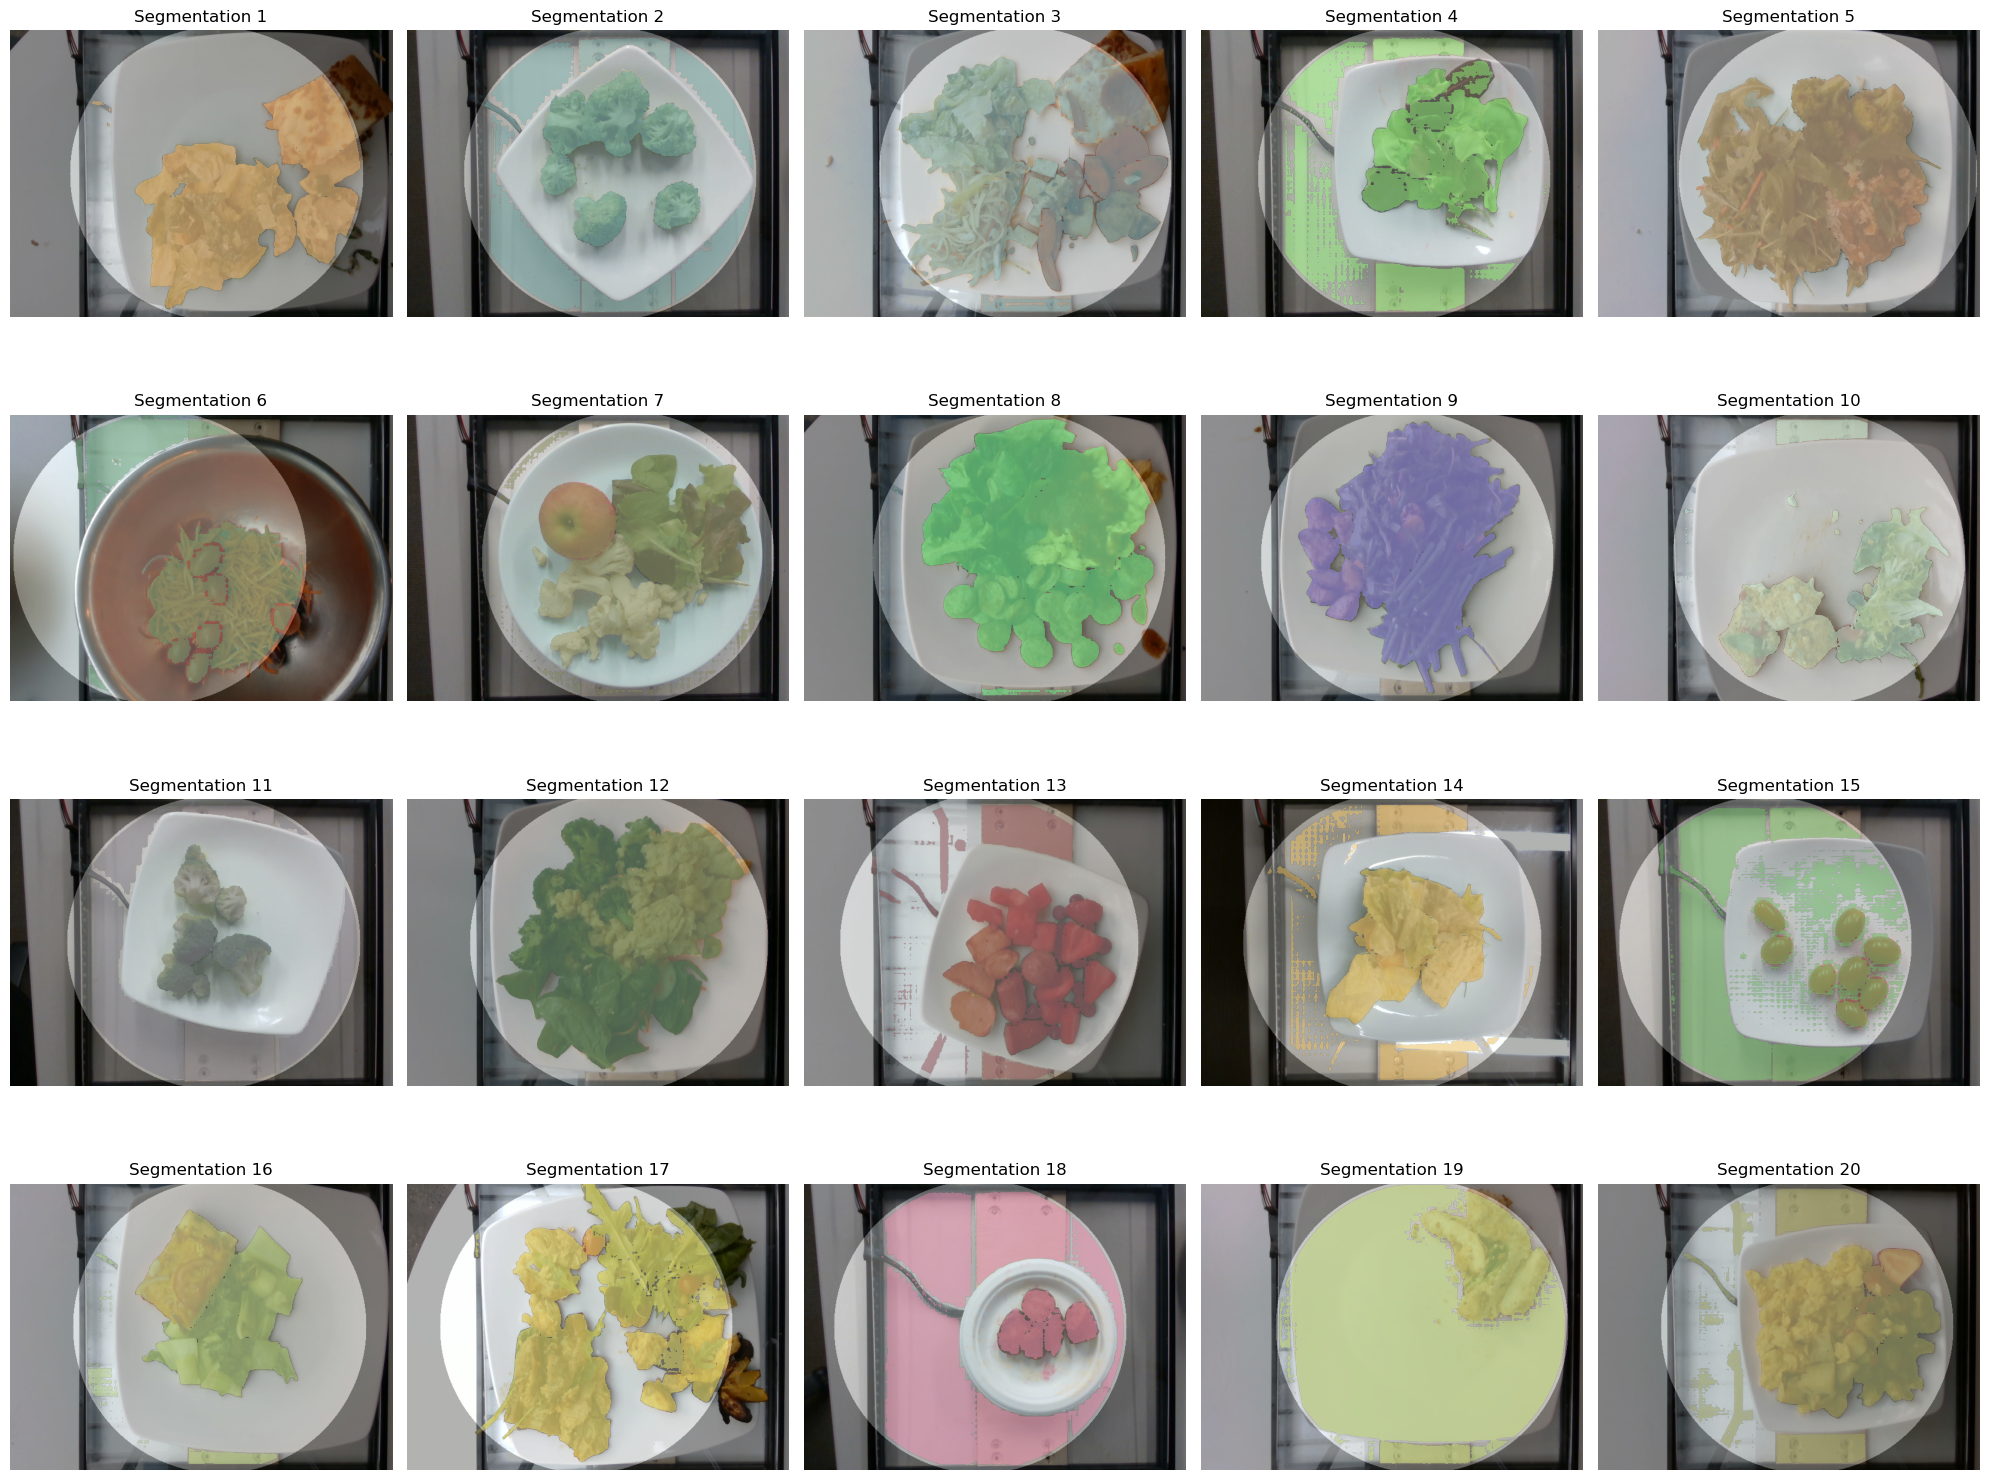

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
TARGET_COLUMNS = ["calories", "weight", "fat", "carbs", "protein"]

# SAM model configuration
SAM_CHECKPOINT = "sam_vit_h_4b8939.pth"  # You'll need to download this
SAM_MODEL_TYPE = "vit_h"

def load_sam_model():
    """Load the SAM model."""
    sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
    sam.to(device=DEVICE)
    return sam

def remove_shadows(image):
    """Remove shadows from the image while preserving important color information."""
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    
    # Merge channels back
    lab = cv2.merge([l, a, b])
    
    # Convert back to RGB
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # Apply bilateral filter to reduce noise while preserving edges
    rgb = cv2.bilateralFilter(rgb, 9, 75, 75)
    
    return rgb

def preprocess_image(image):
    """Preprocess image to identify dish boundaries using adaptive shape analysis."""
    # Get image dimensions
    h, w = image.shape[:2]
    initial_center_x, initial_center_y = w // 2, h // 2
    
    # Remove shadows and enhance image
    enhanced_image = remove_shadows(image)
    
    # Convert to HSV for better color analysis
    hsv = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2HSV)
    
    # Initialize variables for dish detection
    max_radius = min(w, h)
    min_radius = 20  # Minimum radius to consider
    step_size = 5    # Step size for radius increase
    color_threshold = 5  # Lower threshold for more gradual detection
    min_dish_radius = min(w, h) // 2  # Minimum expected dish radius
    
    def get_region_color(center_x, center_y, radius):
        """Get average color in a region around the given center."""
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (center_x, center_y), radius, 255, -1)
        
        # Get mean color and standard deviation
        mean_color = cv2.mean(hsv, mask=mask)[:3]
        std_color = cv2.meanStdDev(hsv, mask=mask)[1][:3, 0]
        
        # If standard deviation is high, the region might contain shadows
        if np.mean(std_color) > 30:  # Threshold for shadow detection
            angles = np.linspace(0, 2*np.pi, 16)
            colors = []
            for angle in angles:
                x = int(center_x + radius * np.cos(angle))
                y = int(center_y + radius * np.sin(angle))
                if 0 <= x < w and 0 <= y < h:
                    colors.append(hsv[y, x])
            
            if colors:
                colors = np.array(colors)
                mean_color = np.median(colors, axis=0)
        
        return mean_color
    
    def find_best_center(radius):
        """Find the best center point for the given radius."""
        best_center = (initial_center_x, initial_center_y)
        best_stability = float('inf')
        
        search_radius = radius // 2
        for dx in range(-search_radius, search_radius + 1, step_size):
            for dy in range(-search_radius, search_radius + 1, step_size):
                center_x = initial_center_x + dx
                center_y = initial_center_y + dy
                
                if (center_x < radius or center_x > w - radius or 
                    center_y < radius or center_y > h - radius):
                    continue
                
                angles = np.linspace(0, 2*np.pi, 16)
                colors = []
                for angle in angles:
                    x = int(center_x + radius * np.cos(angle))
                    y = int(center_y + radius * np.sin(angle))
                    if 0 <= x < w and 0 <= y < h:
                        colors.append(hsv[y, x])
                
                if colors:
                    colors = np.array(colors)
                    stability = np.median(np.abs(colors - np.median(colors, axis=0)), axis=0).mean()
                    if stability < best_stability:
                        best_stability = stability
                        best_center = (center_x, center_y)
        
        return best_center
    
    # Find initial center and radius
    center_x, center_y = initial_center_x, initial_center_y
    prev_color = get_region_color(center_x, center_y, min_radius)
    dish_radius = min_radius
    
    # First pass: find approximate dish size
    for radius in range(min_radius + step_size, max_radius, step_size):
        if radius % (step_size * 4) == 0:
            center_x, center_y = find_best_center(radius)
        
        current_color = get_region_color(center_x, center_y, radius)
        color_diff = np.linalg.norm(np.array(current_color) - np.array(prev_color))
        
        if color_diff > color_threshold and radius > min_dish_radius:
            dish_radius = radius
            break
        
        prev_color = current_color
    
    # Ensure minimum dish radius
    dish_radius = max(dish_radius, min_dish_radius)
    
    # Create initial mask
    dish_mask = np.zeros((h, w), dtype=np.uint8)
    
    # Create a more natural shape by analyzing color transitions
    def analyze_region(x, y, radius):
        """Analyze if a point belongs to the dish based on color transitions."""
        if not (0 <= x < w and 0 <= y < h):
            return False
            
        # Get color at point
        point_color = hsv[y, x]
        
        # Get colors in small neighborhood
        neighborhood = hsv[max(0, y-2):min(h, y+3), max(0, x-2):min(w, x+3)]
        if neighborhood.size == 0:
            return False
            
        # Calculate color difference from center
        center_color = get_region_color(center_x, center_y, radius)
        color_diff = np.linalg.norm(point_color - center_color)
        
        # Calculate distance from center
        dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        
        # Point belongs to dish if:
        # 1. Color is similar to center
        # 2. Distance is within reasonable range
        # 3. Not too far from previous dish points
        return (color_diff < color_threshold * 1.5 and 
                dist < radius * 1.2 and
                (dist < radius * 0.8 or  # Always include points close to center
                 np.any(dish_mask[max(0, y-3):min(h, y+4), max(0, x-3):min(w, x+4)])))  # Or near existing dish points
    
    # Start from center and expand outward
    points_to_check = [(center_x, center_y)]
    checked_points = set()
    
    while points_to_check:
        x, y = points_to_check.pop(0)
        if (x, y) in checked_points:
            continue
            
        checked_points.add((x, y))
        
        if analyze_region(x, y, dish_radius):
            dish_mask[y, x] = 255
            
            # Add neighboring points to check
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]:
                new_x, new_y = x + dx, y + dy
                if (new_x, new_y) not in checked_points:
                    points_to_check.append((new_x, new_y))
    
    # Clean up the mask
    kernel = np.ones((3,3), np.uint8)
    dish_mask = cv2.morphologyEx(dish_mask, cv2.MORPH_CLOSE, kernel)
    dish_mask = cv2.morphologyEx(dish_mask, cv2.MORPH_OPEN, kernel)
    
    # Find the bounding box of the mask
    y_indices, x_indices = np.where(dish_mask > 0)
    if len(y_indices) > 0 and len(x_indices) > 0:
        x = np.min(x_indices)
        y = np.min(y_indices)
        w = np.max(x_indices) - x + 1
        h = np.max(y_indices) - y + 1
    else:
        # Fallback to circular mask if no points found
        cv2.circle(dish_mask, (center_x, center_y), dish_radius, 255, -1)
        x = max(0, center_x - dish_radius)
        y = max(0, center_y - dish_radius)
        w = min(image.shape[1] - x, dish_radius * 2)
        h = min(image.shape[0] - y, dish_radius * 2)
    
    dish_bbox = (x, y, w, h)
    
    return dish_bbox, dish_mask

def segment_food_dish(image_path, sam_model):
    """Segment a food dish using SAM with enhanced food detection using dish information."""
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Preprocess to find dish
    dish_bbox, dish_mask = preprocess_image(image)
    x, y, w, h = dish_bbox
    
    # Create predictor for point-based segmentation
    predictor = SamPredictor(sam_model)
    predictor.set_image(image)
    
    # Create points focusing on the dish area
    points = []
    
    # Add points in a grid pattern within the dish
    for px in range(x + 10, x + w - 10, 15):  # Tighter grid
        for py in range(y + 10, y + h - 10, 15):
            # Only add points where dish is detected
            if dish_mask[py, px] > 0:
                points.append([px, py])
    
    # Add points in a circular pattern within the dish
    center_x, center_y = x + w//2, y + h//2
    radius = min(w, h) // 4  # Smaller radius
    for angle in range(0, 360, 8):  # More points in circle
        rad = np.radians(angle)
        px = center_x + int(radius * np.cos(rad))
        py = center_y + int(radius * np.sin(rad))
        if 0 <= px < image.shape[1] and 0 <= py < image.shape[0]:
            if dish_mask[py, px] > 0:
                points.append([px, py])
    
    # Convert points to numpy array
    input_points = np.array(points)
    
    # Create a tighter bounding box for the dish
    input_box = np.array([
        x + w//8, y + h//8,  # Start slightly inside
        x + w*7//8, y + h*7//8  # End slightly inside
    ])
    
    # Generate masks using both point and box prompts
    masks, scores, _ = predictor.predict(
        point_coords=input_points,
        point_labels=np.ones(len(input_points)),
        box=input_box,
        multimask_output=True
    )
    
    # Select the best mask based on score
    best_mask_idx = np.argmax(scores)
    best_mask = masks[best_mask_idx]
    
    # Refine the mask by adding more points around the detected area
    if np.any(best_mask):
        # Find the bounding box of the detected area
        y_indices, x_indices = np.where(best_mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            min_x, max_x = np.min(x_indices), np.max(x_indices)
            min_y, max_y = np.min(y_indices), np.max(y_indices)
            
            # Add more points around the detected area
            refine_points = []
            for px in range(min_x, max_x, 8):  # Even denser grid for refinement
                for py in range(min_y, max_y, 8):
                    if best_mask[py, px]:  # Only add points where we detected food
                        refine_points.append([px, py])
            
            if refine_points:
                refine_points = np.array(refine_points)
                # Generate refined mask
                refined_masks, refined_scores, _ = predictor.predict(
                    point_coords=refine_points,
                    point_labels=np.ones(len(refine_points)),
                    box=input_box,
                    multimask_output=True
                )
                
                # Update best mask if refined mask is better
                if np.max(refined_scores) > scores[best_mask_idx]:
                    best_mask = refined_masks[np.argmax(refined_scores)]
    
    # Create a list of masks in the format expected by visualization
    mask_list = [{
        'segmentation': best_mask,
        'area': np.sum(best_mask),
        'bbox': [min_x, min_y, max_x - min_x, max_y - min_y] if 'min_x' in locals() else [x, y, w, h],
        'predicted_iou': scores[best_mask_idx],
        'stability_score': scores[best_mask_idx],
        'crop_box': [x, y, w, h],
        'point_coords': input_points.tolist()
    }]
    
    # Apply additional constraints to the final mask
    if np.any(best_mask):
        # Create a circular constraint mask
        constraint_mask = np.zeros_like(best_mask, dtype=np.uint8)  # Changed to uint8
        center_x, center_y = x + w//2, y + h//2
        radius = min(w, h) // 2
        cv2.circle(constraint_mask, (center_x, center_y), radius, 1, -1)
        
        # Convert constraint mask to boolean for the logical operation
        constraint_mask = constraint_mask.astype(bool)
        
        # Apply the constraint mask
        best_mask = np.logical_and(best_mask, constraint_mask)
        
        # Update the mask in the list
        mask_list[0]['segmentation'] = best_mask
    
    return image, mask_list, dish_mask

def visualize_segmentation(image, masks, dish_mask=None):
    """Visualize the segmentation results with enhanced visualization."""
    plt.figure(figsize=(15, 10))
    
    # Original image
    plt.subplot(221)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Dish mask
    if dish_mask is not None:
        plt.subplot(222)
        plt.imshow(dish_mask, cmap='gray')
        plt.title('Dish Detection')
        plt.axis('off')
    
    # Segmentation mask
    plt.subplot(223)
    plt.imshow(image)
    for mask in masks:
        show_mask(mask['segmentation'], plt.gca(), random_color=False)
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    # Overlay with points
    plt.subplot(224)
    plt.imshow(image)
    for mask in masks:
        show_mask(mask['segmentation'], plt.gca(), random_color=True)
        # Show the points used for segmentation
        if 'point_coords' in mask:
            points = np.array(mask['point_coords'])
            plt.scatter(points[:, 0], points[:, 1], c='yellow', s=10, alpha=0.5)
    plt.title('Overlay with Points')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def show_mask(mask, ax, random_color=False):
    """Show a mask on the given axis with improved visibility."""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.5])], axis=0)
    else:
        color = np.array([1, 0, 0, 0.5])  # Red with 50% opacity
    
    # Handle both single mask and list of masks
    if isinstance(mask, list):
        mask = mask[0]['segmentation']  # Get the first mask's segmentation
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def visualize_segmentation_grid(images, masks, dish_masks=None, num_cols=5):
    """Create a grid visualization of segmentation masks."""
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    plt.figure(figsize=(20, 4 * num_rows))
    
    for idx in range(num_images):
        plt.subplot(num_rows, num_cols, idx + 1)
        # Show original image as background
        plt.imshow(images[idx])
        # Overlay segmentation mask
        show_mask(masks[idx], plt.gca(), random_color=True)
        if dish_masks is not None:
            plt.imshow(dish_masks[idx], alpha=0.3, cmap='gray')
        plt.title(f'Segmentation {idx + 1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def process_batch(image_paths, sam_model, batch_size=4):
    """Process a batch of images in parallel."""
    results = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_results = []
        
        for image_path in batch_paths:
            try:
                image, mask, dish_mask = segment_food_dish(image_path, sam_model)
                batch_results.append((image, mask, dish_mask))
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                continue
        
        results.extend(batch_results)
    
    return results

# Find available dish IDs with images
available_dish_ids_in_imagery = []
for dish_id_folder in os.listdir(IMAGERY_DIR_LOCAL_FULL):
    rgb_path = os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id_folder, RGB_IMAGE_FILENAME)
    if os.path.isdir(
        os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id_folder)
    ) and os.path.exists(rgb_path):
        available_dish_ids_in_imagery.append(dish_id_folder)

print(f"Found {len(available_dish_ids_in_imagery)} dish IDs with RGB images")

if __name__ == "__main__":
    # Load SAM model    
    print("Loading SAM model...")
    sam = load_sam_model()
    
    # Get random sample of dish IDs
    num_images = 20
    random_dish_ids = np.random.choice(available_dish_ids_in_imagery, size=num_images, replace=False)
    
    # Prepare image paths
    image_paths = [os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id, RGB_IMAGE_FILENAME) 
                  for dish_id in random_dish_ids]
    
    # Process images in batches
    print("Processing images in batches...")
    results = process_batch(image_paths, sam, batch_size=4)
    
    # Unpack results
    images = [r[0] for r in results]
    masks = [r[1] for r in results]
    dish_masks = [r[2] for r in results]
    
    # Create grid visualization
    print("Creating visualization...")
    visualize_segmentation_grid(images, masks, dish_masks)

In [ ]:
# Configuration
LOCAL_BASE_DIR = "/Data/aa/FoodCNN/datasets/nutrition5k"
IMAGERY_DIR_LOCAL_FULL = os.path.join(LOCAL_BASE_DIR, "imagery/realsense_overhead")
METADATA_FILE_CAFE1 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe1.csv")
METADATA_FILE_CAFE2 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe2.csv")
RGB_IMAGE_FILENAME = "rgb.png"

 ## Data Loading and Preprocessing

In [ ]:
def parse_nutrition_csv(file_path):
    """Parse nutrition CSV files to extract dish and ingredient data."""
    dishes = []
    ingredients_list = []

    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if not parts[0].startswith("dish_"):
                continue

            dish_id = parts[0]
            dish_calories = float(parts[1])
            dish_weight = float(parts[2])
            dish_fat = float(parts[3])
            dish_carbs = float(parts[4])
            dish_protein = float(parts[5])

            dishes.append(
                {
                    "dish_id": dish_id,
                    "calories": dish_calories,
                    "weight": dish_weight,
                    "fat": dish_fat,
                    "carbs": dish_carbs,
                    "protein": dish_protein,
                }
            )

            # Extract ingredients (in groups of 7 fields)
            ingredient_data = parts[6:]
            i = 0
            while i < len(ingredient_data) - 6:
                if not ingredient_data[i].startswith("ingr_"):
                    break

                ingredients_list.append(
                    {
                        "dish_id": dish_id,
                        "ingredient_id": ingredient_data[i],
                        "ingredient_name": ingredient_data[i + 1],
                        "amount": float(ingredient_data[i + 2]),
                        "calories": float(ingredient_data[i + 3]),
                        "fat": float(ingredient_data[i + 4]),
                        "carbs": float(ingredient_data[i + 5]),
                        "protein": float(ingredient_data[i + 6]),
                    }
                )
                i += 7

    # Create two separate dataframes
    dish_df = pd.DataFrame(dishes)
    ingredient_df = pd.DataFrame(ingredients_list)

    return dish_df, ingredient_df

In [ ]:
# Load and parse data
dish_df_cafe1, ingredient_df_cafe1 = parse_nutrition_csv(METADATA_FILE_CAFE1)
dish_df_cafe2, ingredient_df_cafe2 = parse_nutrition_csv(METADATA_FILE_CAFE2)

# Combine datasets
dish_metadata_df = pd.concat([dish_df_cafe1, dish_df_cafe2], ignore_index=True)
ingredient_metadata_df = pd.concat(
    [ingredient_df_cafe1, ingredient_df_cafe2], ignore_index=True
)

print(f"Combined dish metadata shape: {dish_metadata_df.shape}")

Combined dish metadata shape: (5006, 6)


In [ ]:
filtered_metadata_df = dish_metadata_df[
    dish_metadata_df["dish_id"].isin(available_dish_ids_in_imagery)
].copy()
print(
    f"Filtered dish metadata to {len(filtered_metadata_df)} dishes with available imagery"
)

for col in TARGET_COLUMNS:
    filtered_metadata_df[col] = pd.to_numeric(
        filtered_metadata_df[col], errors="coerce"
    )
filtered_metadata_df.dropna(subset=TARGET_COLUMNS, inplace=True)
print(
    f"Dish metadata after dropping NaNs in target columns: {len(filtered_metadata_df)} dishes"
)

dish_ids_for_dataset = filtered_metadata_df["dish_id"].tolist()
labels_for_dataset = filtered_metadata_df[TARGET_COLUMNS].values.astype(np.float32)

train_dish_ids, val_dish_ids, train_labels, val_labels = train_test_split(
    dish_ids_for_dataset, labels_for_dataset, test_size=0.2, random_state=42
)
print(
    f"Training samples: {len(train_dish_ids)}, Validation samples: {len(val_dish_ids)}"
)

Filtered dish metadata to 3490 dishes with available imagery
Dish metadata after dropping NaNs in target columns: 3490 dishes
Training samples: 2792, Validation samples: 698


In [ ]:
class NutritionDataset(Dataset):
    """Dataset for loading food images and their nutritional values."""

    def __init__(self, dish_ids, labels, imagery_dir, rgb_filename, transform=None):
        self.dish_ids = dish_ids
        self.labels = labels
        self.imagery_dir = imagery_dir
        self.rgb_filename = rgb_filename
        self.transform = transform

    def __len__(self):
        return len(self.dish_ids)

    def __getitem__(self, idx):
        dish_id = self.dish_ids[idx]

        # Load RGB image
        img_path = os.path.join(self.imagery_dir, dish_id, self.rgb_filename)
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"ERROR: Image not found at {img_path} for dish_id {dish_id}")
            # Return a dummy image and label
            return torch.zeros(3, 224, 224), torch.zeros(len(TARGET_COLUMNS))

        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)

        return image, label_tensor

In [ ]:
# Define transformations
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)), 
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
            ),  
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),  
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
}

In [ ]:

BATCH_SIZE = 32
train_dataset = NutritionDataset(
    dish_ids=train_dish_ids,
    labels=train_labels,
    imagery_dir=IMAGERY_DIR_LOCAL_FULL,
    rgb_filename=RGB_IMAGE_FILENAME,
    transform=data_transforms["train"],
)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
print(f"Train dataset created with {len(train_dataset)} samples")

val_dataset = NutritionDataset(
    dish_ids=val_dish_ids,
    labels=val_labels,
    imagery_dir=IMAGERY_DIR_LOCAL_FULL,
    rgb_filename=RGB_IMAGE_FILENAME,
    transform=data_transforms["val"],
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)
print(f"Validation dataset created with {len(val_dataset)} samples")

Train dataset created with 2792 samples
Validation dataset created with 698 samples


In [ ]:

def apply_segmentation_mask(image, mask):
    """
    Apply segmentation mask to an image, blacking out non-segmented regions.
    
    Args:
        image: numpy array of shape (H, W, 3)
        mask: boolean array of shape (H, W)
    
    Returns:
        masked_image: numpy array of shape (H, W, 3) with non-segmented regions blacked out
    """
    # Ensure mask is boolean
    if not mask.dtype == bool:
        mask = mask.astype(bool)
    
    # Create a copy of the image to avoid modifying the original
    masked_image = image.copy()
    
    # Apply mask - set pixels outside the mask to black (0)
    masked_image[~mask] = 0
    
    return masked_image

def process_and_save_segmented_images(dish_ids, imagery_dir, output_dir, sam_model):
    """
    Process images with segmentation and save the masked versions.
    
    Args:
        dish_ids: list of dish IDs to process
        imagery_dir: directory containing original images
        output_dir: directory to save processed images
        sam_model: SAM model for segmentation
    
    Returns:
        List of successfully processed dish IDs
    """
    os.makedirs(output_dir, exist_ok=True)
    successful_ids = []
    
    for i, dish_id in enumerate(dish_ids):
        try:
            # Create output directory for this dish
            dish_output_dir = os.path.join(output_dir, dish_id)
            os.makedirs(dish_output_dir, exist_ok=True)
            
            img_path = os.path.join(imagery_dir, dish_id, RGB_IMAGE_FILENAME)
            if not os.path.exists(img_path):
                print(f"Image not found for dish_id: {dish_id}")
                continue
                
            image, masks, dish_mask = segment_food_dish(img_path, sam_model)
            
            if masks and len(masks) > 0:
                best_mask = masks[0]['segmentation']
                
                masked_image = apply_segmentation_mask(image, best_mask)
                
                output_path = os.path.join(dish_output_dir, "masked_rgb.png")
                plt.imsave(output_path, masked_image)
                
                successful_ids.append(dish_id)
                
                if (i + 1) % 10 == 0:
                    print(f"Processed {i + 1}/{len(dish_ids)} images")
            else:
                print(f"Segmentation failed for dish_id: {dish_id}")
                
        except Exception as e:
            print(f"Error processing dish_id {dish_id}: {str(e)}")
    
    return successful_ids

class SegmentedNutritionDataset(Dataset):
    """dataset for loading segmented food images and their nutritional values and segment on the fly, as needed"""

    def __init__(self, dish_ids, labels, imagery_dir, rgb_filename="masked_rgb.png", transform=None, 
                 sam_model=None, original_imagery_dir=None, use_cached=True):
        self.dish_ids = dish_ids
        self.labels = labels
        self.imagery_dir = imagery_dir
        self.rgb_filename = rgb_filename
        self.transform = transform
        self.use_cached = use_cached
        self.sam_model = sam_model
        self.original_imagery_dir = original_imagery_dir

    def __len__(self):
        return len(self.dish_ids)

    def __getitem__(self, idx):
        dish_id = self.dish_ids[idx]
        
        if self.use_cached:
            img_path = os.path.join(self.imagery_dir, dish_id, self.rgb_filename)
            try:
                image = Image.open(img_path).convert("RGB")
            except FileNotFoundError:
                print(f"ERROR: Segmented image not found for dish_id {dish_id}")
                return torch.zeros(3, 224, 224), torch.zeros(len(TARGET_COLUMNS))
        else:
            if self.sam_model is None:
                raise ValueError("SAM model is required for on-the-fly segmentation")
            
            orig_img_path = os.path.join(self.original_imagery_dir, dish_id, "rgb.png")
            try:
                orig_image, masks, _ = segment_food_dish(orig_img_path, self.sam_model)
                
                if masks and len(masks) > 0:
                    best_mask = masks[0]['segmentation']
                    masked_image = apply_segmentation_mask(orig_image, best_mask)
                    image = Image.fromarray(masked_image.astype('uint8'))
                else:
                    image = Image.fromarray(orig_image.astype('uint8'))
            except Exception as e:
                print(f"Error segmenting dish_id {dish_id}: {str(e)}")
                return torch.zeros(3, 224, 224), torch.zeros(len(TARGET_COLUMNS))

        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)

        return image, label_tensor

Processing and saving segmented images...
Processed 10/60 images
Processed 20/60 images
Processed 30/60 images
Processed 40/60 images
Processed 50/60 images
Processed 60/60 images
Successfully processed 60 out of 60 images
Created segmented train dataset with 50 samples
Created segmented val dataset with 10 samples
Visualizing samples from segmented dataset:


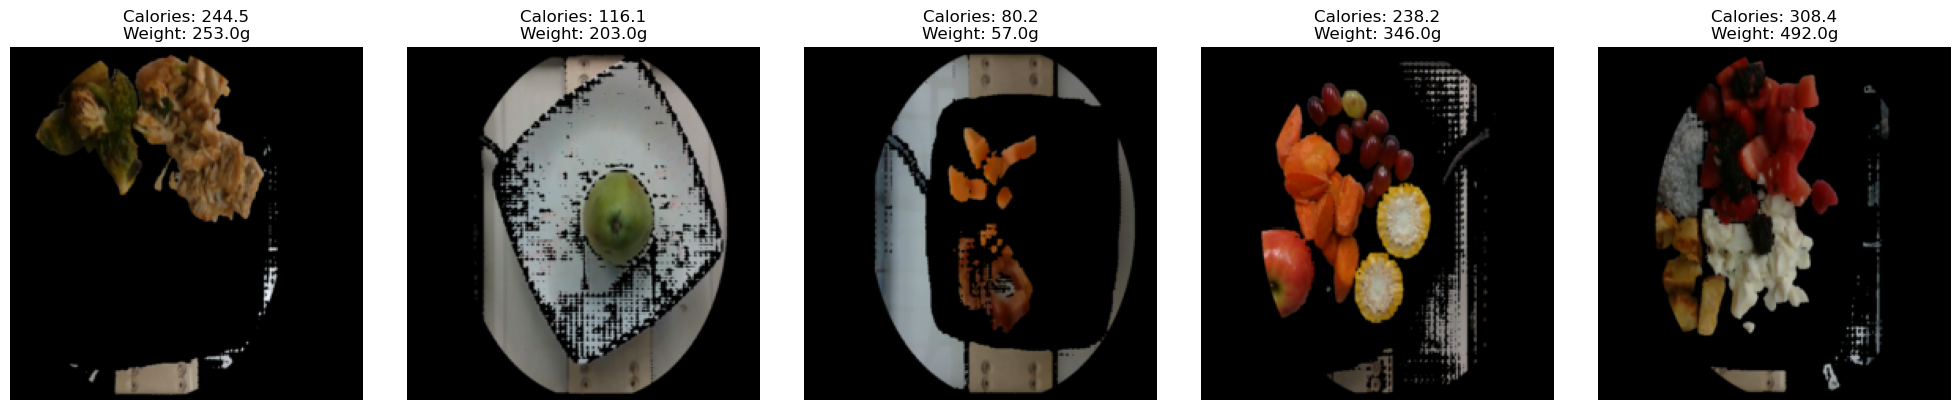

In [ ]:
if __name__ == "__main__":
    if 'sam' not in locals():
        print("Loading SAM model...")
        sam = load_sam_model()
    
    SEGMENTED_IMAGERY_DIR = os.path.join(LOCAL_BASE_DIR, "imagery/segmented_dishes")
    os.makedirs(SEGMENTED_IMAGERY_DIR, exist_ok=True)
    
    print("Processing and saving segmented images...")
    test_dish_ids = train_dish_ids[:50] + val_dish_ids[:10]  
    successful_ids = process_and_save_segmented_images(
        test_dish_ids, 
        IMAGERY_DIR_LOCAL_FULL, 
        SEGMENTED_IMAGERY_DIR, 
        sam
    )
    
    print(f"Successfully processed {len(successful_ids)} out of {len(test_dish_ids)} images")
    train_successful_indices = [i for i, dish_id in enumerate(train_dish_ids) if dish_id in successful_ids]
    val_successful_indices = [i for i, dish_id in enumerate(val_dish_ids) if dish_id in successful_ids]
    
    train_segmented_dish_ids = [train_dish_ids[i] for i in train_successful_indices]
    train_segmented_labels = train_labels[train_successful_indices]
    
    val_segmented_dish_ids = [val_dish_ids[i] for i in val_successful_indices]
    val_segmented_labels = val_labels[val_successful_indices]
    
    segmented_train_dataset = SegmentedNutritionDataset(
        dish_ids=train_segmented_dish_ids,
        labels=train_segmented_labels,
        imagery_dir=SEGMENTED_IMAGERY_DIR,
        transform=data_transforms["train"],
        use_cached=True
    )
    
    segmented_val_dataset = SegmentedNutritionDataset(
        dish_ids=val_segmented_dish_ids,
        labels=val_segmented_labels,
        imagery_dir=SEGMENTED_IMAGERY_DIR,
        transform=data_transforms["val"],
        use_cached=True
    )
    
    segmented_train_loader = DataLoader(
        segmented_train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=2
    )
    
    segmented_val_loader = DataLoader(
        segmented_val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=2
    )
    
    print(f"Created segmented train dataset with {len(segmented_train_dataset)} samples")
    print(f"Created segmented val dataset with {len(segmented_val_dataset)} samples")
    
    def visualize_segmented_samples(dataset, num_samples=5):
        """Visualize samples from the segmented dataset"""
        fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
        
        for i in range(num_samples):
            idx = np.random.randint(len(dataset))
            img, label = dataset[idx]
            
            img_np = img.numpy().transpose(1, 2, 0)
            img_np = (img_np * 0.5 + 0.5).clip(0, 1) 
            
            axes[i].imshow(img_np)
            axes[i].set_title(f"Calories: {label[0]:.1f}\nWeight: {label[1]:.1f}g")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    print("Visualizing samples from segmented dataset:")
    visualize_segmented_samples(segmented_train_dataset)